In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sandp500/merge.sh
/kaggle/input/sandp500/getSandP.py
/kaggle/input/sandp500/all_stocks_5yr.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._.DS_Store
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._ABC_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._AAPL_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._A_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._MAS_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/CL_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/FDX_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/AMAT_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/GLW_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/ANSS_data.csv
/kaggle/input/sandp500/individual_stock

# Intro

- In this we will forecast stock prices using Prophet which is Facebook's library for time series forecasting


# Explore dataset

## Import Libraries

In [2]:
!pip install chart-studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.1 MB/s eta 0:00:00


In [3]:
import datetime as dt
# from pandas.core import datetools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import statsmodels.api as sm
from scipy import stats


from plotly import tools
from chart_studio import plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected = True)

import warnings
# warnings.filterwarnings("ignore")

# plt.style.use("seaborn-whitegrid")

In [4]:
df = pd.read_csv('/kaggle/input/sandp500/all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [6]:
df = df.rename(columns={'Name': 'Ticks'})

We will be analyzing Amazon's stck and look for the trend

In [7]:
amzn = df.loc[df['Ticks'] == 'AMZN']
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [8]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Ticks   1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


We will have to convert date to datetime for our analysis

In [9]:
amzn_df = amzn.copy()
amzn_df['date'] = amzn_df['date'].apply(pd.to_datetime) 

In [10]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Ticks   1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


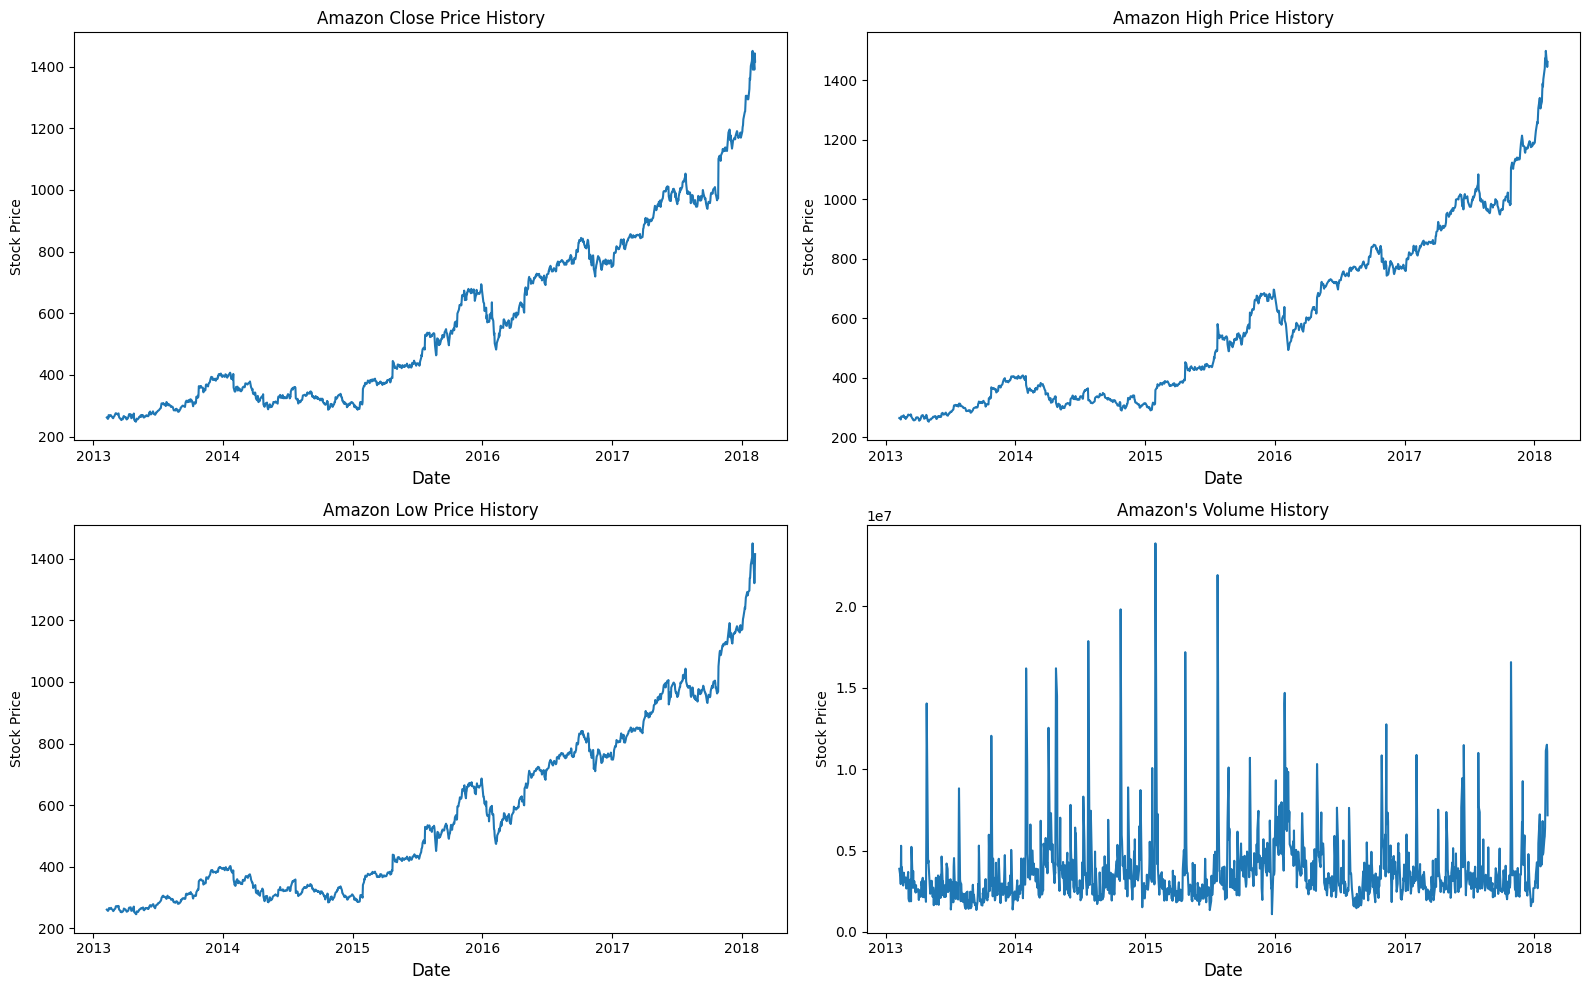

In [11]:
# simple plotting of Amazon Stock Price
fig, ((ax_1, ax_2), (ax_3, ax_4)) = plt.subplots(2, 2, figsize = (16, 10))

ax_1.plot(amzn_df['date'], amzn_df['close'])
ax_1.set_xlabel('Date', fontsize = 12)
ax_1.set_ylabel('Stock Price')
ax_1.set_title('Amazon Close Price History')

ax_2.plot(amzn_df['date'], amzn_df['high'])
ax_2.set_xlabel('Date', fontsize = 12)
ax_2.set_ylabel('Stock Price')
ax_2.set_title('Amazon High Price History')

ax_3.plot(amzn_df['date'], amzn_df['low'])
ax_3.set_xlabel('Date', fontsize = 12)
ax_3.set_ylabel('Stock Price')
ax_3.set_title('Amazon Low Price History')

ax_4.plot(amzn_df['date'], amzn_df['volume'])
ax_4.set_xlabel('Date', fontsize = 12)
ax_4.set_ylabel('Stock Price')
ax_4.set_title("Amazon's Volume History")

plt.tight_layout()
plt.show()

# Using Prophet

- Prophet is Facebooks library for Forecasting
- It works best with dataset highly influenced by seasonality


## Amazon Stock Price Forecast

In [12]:
m = Prophet()

ph_df = amzn_df.drop(['open', 'high', 'low', 'volume', 'Ticks'], axis = 1)
ph_df.rename(columns = {'close': 'y', 'date': 'ds'}, inplace = True)

ph_df.head()

,ds,y
46387,2013-02-08,261.95
46388,2013-02-11,257.21
46389,2013-02-12,258.70
46390,2013-02-13,269.47
46391,2013-02-14,269.24


In [13]:
m.fit(ph_df)

12:18:53 - cmdstanpy - INFO - Chain [1] start processing
12:18:54 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future_prices = m.make_future_dataframe(periods = 365)

forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,1778.260686,1288.255652,2285.521859
1620,2019-02-04,1756.056274,1256.013828,2258.905083
1621,2019-02-05,1755.965583,1255.434697,2286.308773
1622,2019-02-06,1755.747523,1265.025687,2262.812942
1623,2019-02-07,1755.188270,1244.000627,2275.906361


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



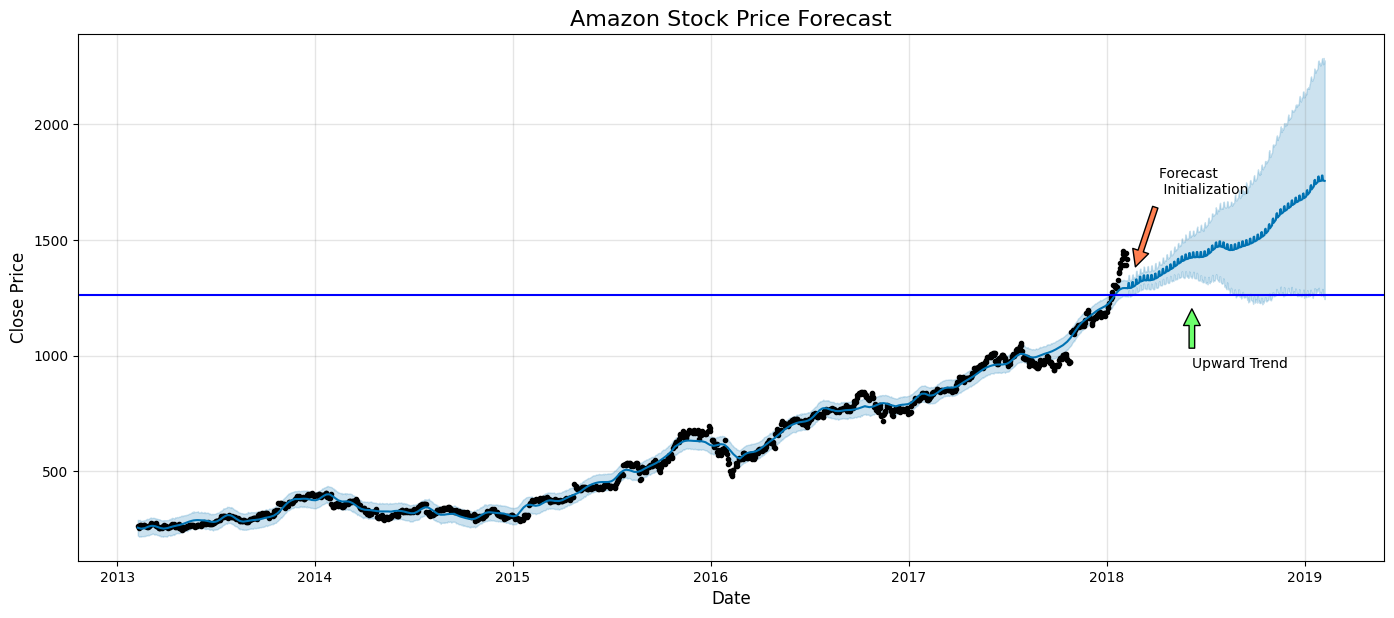

In [15]:

starting_date = dt.datetime(2018, 4, 7)
starting_date_1 = mdates.date2num(starting_date)

trend_date = dt.datetime(2018, 6, 7)
trend_date_1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow_1 = mdates.date2num(pointing_arrow)

fig = plt.figure(figsize=(14, 6))

ax_1 = fig.add_subplot(111)
m.plot(forecast, ax = ax_1)

ax_1.set_title('Amazon Stock Price Forecast', fontsize = 16)
ax_1.set_xlabel('Date', fontsize = 12)
ax_1.set_ylabel('Close Price', fontsize = 12)

ax_1.annotate(
    'Forecast \n Initialization', 
    xy = (pointing_arrow_1, 1350), 
    xytext = (starting_date_1, 1700), 
    arrowprops=dict(facecolor='#ff7f50', shrink = 0.1)
)

ax_1.annotate(
    'Upward Trend', 
    xy=(trend_date_1, 1225), 
    xytext=(trend_date_1, 950), 
    arrowprops=dict(facecolor='#6cff6c', shrink=0.1)
)

ax_1.axhline(y=1260, color='b', linestyle='-')

plt.show()

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



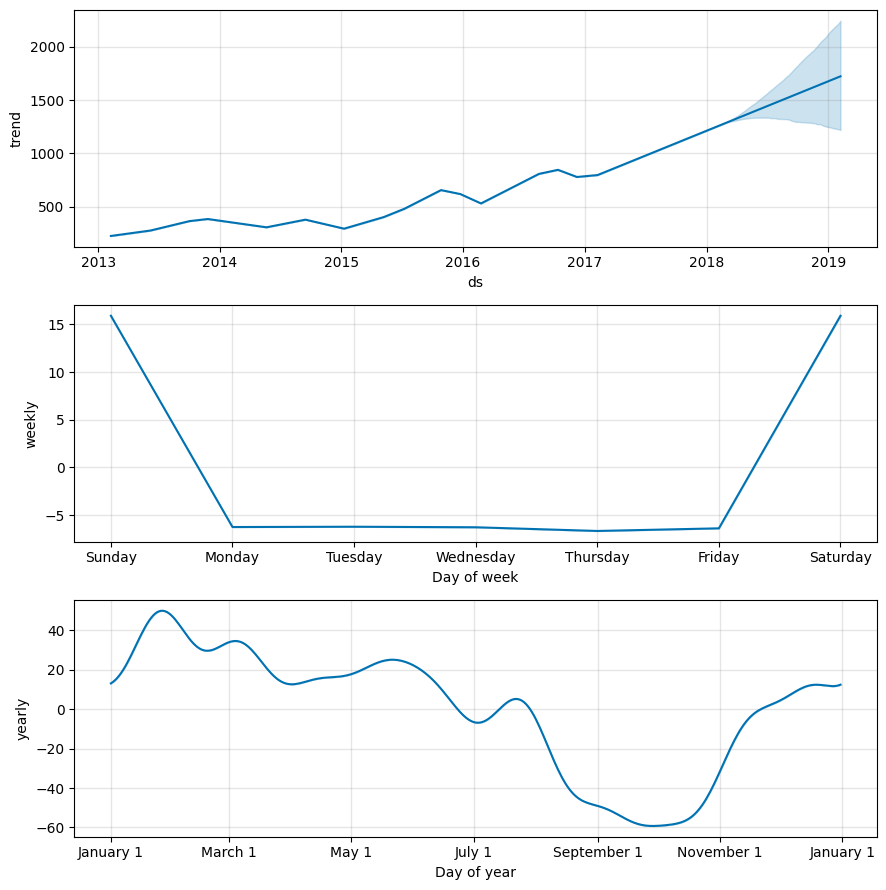

In [16]:
fig_2 = m.plot_components(forecast)
plt.show()

## Monthly data predictions

12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/forecaster.py:1796: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



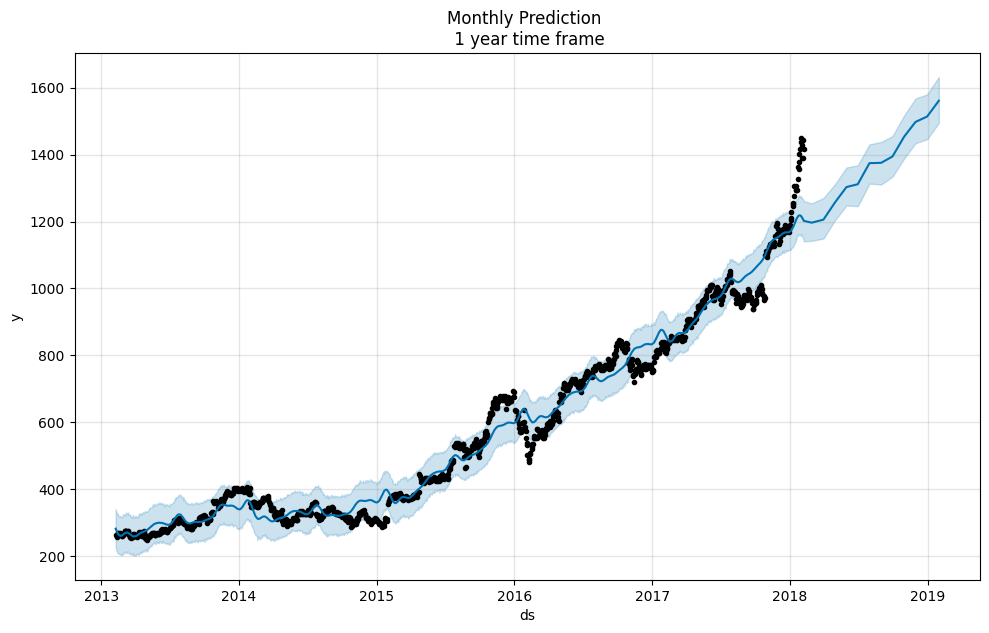

In [17]:

m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods = 12, freq = 'M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title('Monthly Prediction \n 1 year time frame')

plt.show()

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



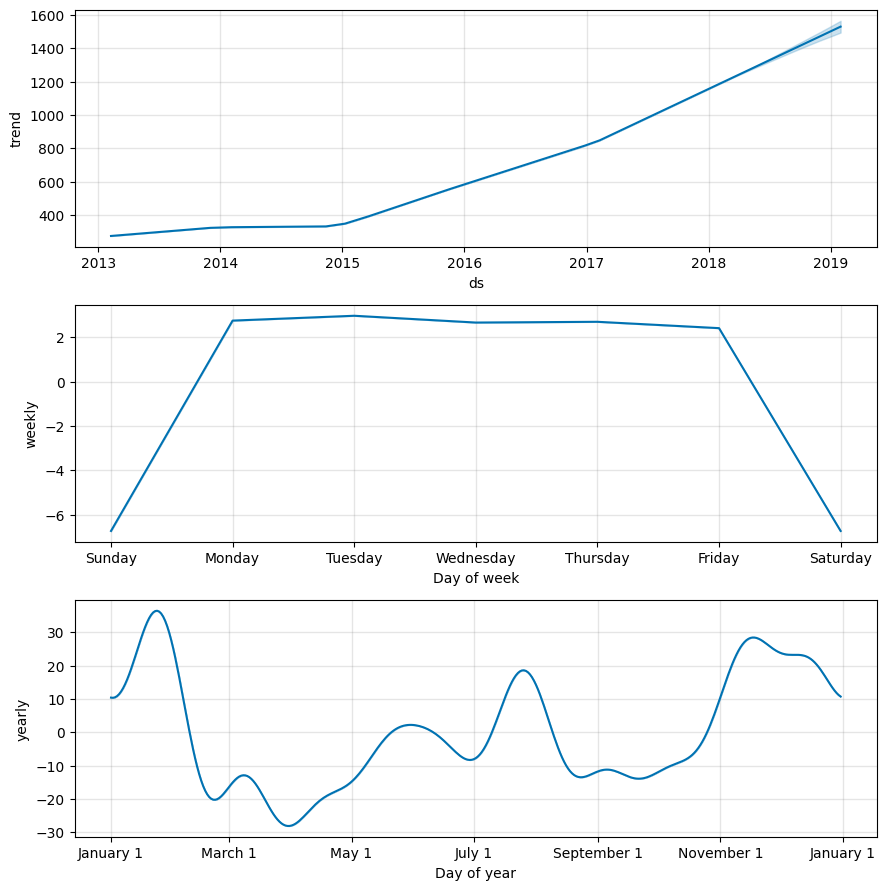

In [18]:
fig = m.plot_components(fcst)
plt.show()

# Technical Analysis

In [19]:
data = go.Ohlc(
            x = amzn_df['date'],
            open = amzn_df['open'],
            high = amzn_df['high'],
            low = amzn_df['low'],
            close = amzn_df['close'],
            increasing = dict(line = dict(color = '#58FA58')),
            decreasing = dict(line = dict(color = '#FA5858'))
        )

layout = {
    'title': 'Amazon Historical Price',
    'xaxis': {
        'title': 'Date',
        'rangeslider': {
            'visible': False
        }
    },
    'yaxis': {
        'title': 'Stock Price (USD$)'
    },
    'shapes': [
        {
            'x0': '2016-12-09',
            'x1': '2016-12-09',
            'y0': 0,
            'y1': 1,
            'xref': 'x',
            'yref': 'paper',
            'line': {
                'color': 'rgb(30, 30, 30)',
                'width': 1
            }
        }
    ],
    'annotations': [{
        'x': '2017-01-20',
        'y': 0.05,
        'xref': 'x',
        'yref': 'paper',
        'showarrow': False,
        'xanchor': 'left',
        'text' : 'President Donal Trump <br> takes Office'
    }]
}


fig = go.Figure(data = data, layout = layout)
# iplot(fig, filename='simple_ohlc')
fig.show()

## Last two years

In [20]:
last_two = amzn_df.loc[amzn_df['date'].dt.year > 2016]
grp = last_two.groupby(['date'])
monthly_averages = grp.aggregate({'open':np.mean, 'high': np.mean, 'low': np.mean, 'close': np.mean})

monthly_averages.reset_index(level = 0, inplace = True)

data = go.Candlestick(
            x = monthly_averages['date'],
            open = monthly_averages['open'].values.tolist(),
            high = monthly_averages['high'].values.tolist(),
            low = monthly_averages['low'].values.tolist(),
            close = monthly_averages['close'].values.tolist(),
            increasing = dict(line=dict(color= '#58FA58')),
            decreasing = dict(line=dict(color= '#FA5858'))
        )

layout = {
    'title': 'Amazon Historical Price <br> <i>For the Last two years</i>',
    'xaxis': {
        'title': 'Date',
        'rangeslider': { 'visible': False }
    },
    'yaxis': {'title' : 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-01-02', 'x1': '2018-01-02',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30, 30, 30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2018-01-07',
        'y': 0.9,
        'xref': 'x',
        'yref': 'paper',
        'showarrow': True,
        'xanchor': 'left',
        'text': 'Upward Trend'
    }]
}



fig = go.Figure(data = data, layout = layout)
# iplot(fig, filename = 'simple_ohlc')
fig.show()

/tmp/ipykernel_17/2055863935.py:3: FutureWarning:

The provided callable <function mean at 0x7cbe84271c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



## Last year

In [21]:
amzn_df['month_year'] = pd.to_datetime(amzn_df['date']).dt.to_period('M')

last_year = amzn_df.loc[amzn_df['date'].dt.year > 2017]
grp_last = last_year.groupby(['date'])
monthly_averages = grp_last.aggregate({
    'open': np.mean,
    'high': np.mean,
    'low': np.mean,
    'close' : np.mean
})
monthly_averages.reset_index(level = 0, inplace = True)

monthly_averages.dtypes

/tmp/ipykernel_17/4226892341.py:5: FutureWarning:

The provided callable <function mean at 0x7cbe84271c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



date     datetime64[ns]
open            float64
high            float64
low             float64
close           float64
dtype: object

In [22]:
trace = go.Candlestick(
            x = monthly_averages['date'],
            open = monthly_averages['open'].values.tolist(),
            high = monthly_averages['high'].values.tolist(),
            low = monthly_averages['low'].values.tolist(),
            close = monthly_averages['close'].values.tolist(),
            increasing = dict(line=dict(color= '#58FA58')),
            decreasing = dict(line=dict(color= '#FA5858'))
        )

layout = {
    'title': 'Amazon Historical Price <br> <i>A closer look on the upwards trend</i>',
    'xaxis': {
        'title': 'Date',
        'rangeslider': { 'visible': False}
    },
    'yaxis': {'title' : 'Stock Price (USD$)'},
}

data = [trace]

fig = go.Figure(data = data, layout = layout)
# iplot(fig, filename = 'simple_ohlc')
fig.show()

In [23]:
amzn_df.head()

,date,open,high,low,close,volume,Ticks,month_year
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,2013-02
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,2013-02
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,2013-02
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,2013-02
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,2013-02


## Moving Averages

In [24]:
amzn_df['10_d_avg'] = amzn_df.close.rolling(window=10).mean()
amzn_df['50_d_avg'] = amzn_df.close.rolling(window=50).mean()
amzn_df['200_d_avg'] = amzn_df.close.rolling(window=200).mean()

close_p = amzn_df['close'].values.tolist()
ten_d = amzn_df['10_d_avg'].values.tolist()
fifty_d = amzn_df['50_d_avg'].values.tolist()
twoh_d = amzn_df['200_d_avg'].values.tolist()
date = amzn_df['date'].values.tolist()

amzn_df = amzn_df.set_index('date')

In [25]:
fig = tls.make_subplots(rows = 2, cols = 1, shared_xaxes = True)
colors = ['#ff4500', '#92a1cf', '#6E6E6E']
avgs = ['10_d_avg', '50_d_avg', '200_d_avg']

for col, c in zip(avgs, colors):
    fig.append_trace({
        'x': amzn_df.index,
        'y': amzn_df[col],
        'type': 'scatter',
        'name': col,
        'line': {'color': c}
    }, 1, 1)

for col in ['close']:
    fig.append_trace({
        'x': amzn_df.index,
        'y': amzn_df[col],
        'type': 'scatter',
        'name': 'Close Price',
        'line': {'color': '#01DF3A'}
    }, 2, 1)

fig['layout'].update(
    height = 800,
    title = 'Relationship between MAs <br> ans Closing Price',
    paper_bgcolor = '#F2DFCE',
    plot_bgcolor = '#F2DFCE'
)

iplot(fig, filename = 'pandas/mixed-type subplots')

/opt/conda/lib/python3.10/site-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [26]:
amzn_df = amzn_df.reset_index()

trace_0 = go.Scatter(
            x = amzn_df['date'],
            y = ten_d,
            name= '10 day MA',
            line = dict( color = '#ff6347', width = 4)
        )

trace_1 = go.Scatter(
            x = amzn_df['date'],
            y = fifty_d,
            name = '50 day MA',
            line = dict( color = '#92a1cf', width = 4, dash = 'dot'),
#             dash = 'dot'
        )

trace_2 = go.Scatter(
            x = amzn_df['date'],
            y = twoh_d,
            name = '200 day MA',
            line = dict(color = '#2EF688', width = 4, dash = 'dash')
        )

data = [trace_0, trace_1 , trace_2]

layout = dict(
            title = 'Moving Averages for Amazon', 
            xaxis = dict(title = 'Date'),
            yaxis = dict(title = 'Price'),
            annotations = [
                dict(
                    x = '2016-01-13',
                    y = 657,
                    xref = 'x',
                    yref = 'y',
                    text = '<i> First major decline <br> after 10d crosses <br> 50 d moving average </i>',
                    
                    showarrow = True,
                    arrowhead = 5,
                    ax = 5,
                    ay = -50
                ),
                dict(
                    x = '2016-02-24',
                    y = 535,
                    text = '<i> Upward trend after <br> 10 day crosses <br> 20 day Moving average</i>',
                    textangle = 0,
                    ax = 50,
                    ay = 50,
                    font = dict(
                        color = 'black',
                        size = 12
                    )
                )
            ],
            paper_bgcolor = '#FFF9F5',
            plot_bgcolor = '#FFF9F5'
        )

fig = dict(data = data, layout = layout)
iplot(fig, filename = 'styled-line')

# Stocks more susceptible to seasonality trend

## American Airlines

In [27]:
aal_df = df.loc[df['Ticks'] == 'AAL']
aal_df.loc[:, 'date'] = pd.to_datetime(aal_df.loc[:, 'date'], format="%Y-%m-%d")

aal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Ticks   1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


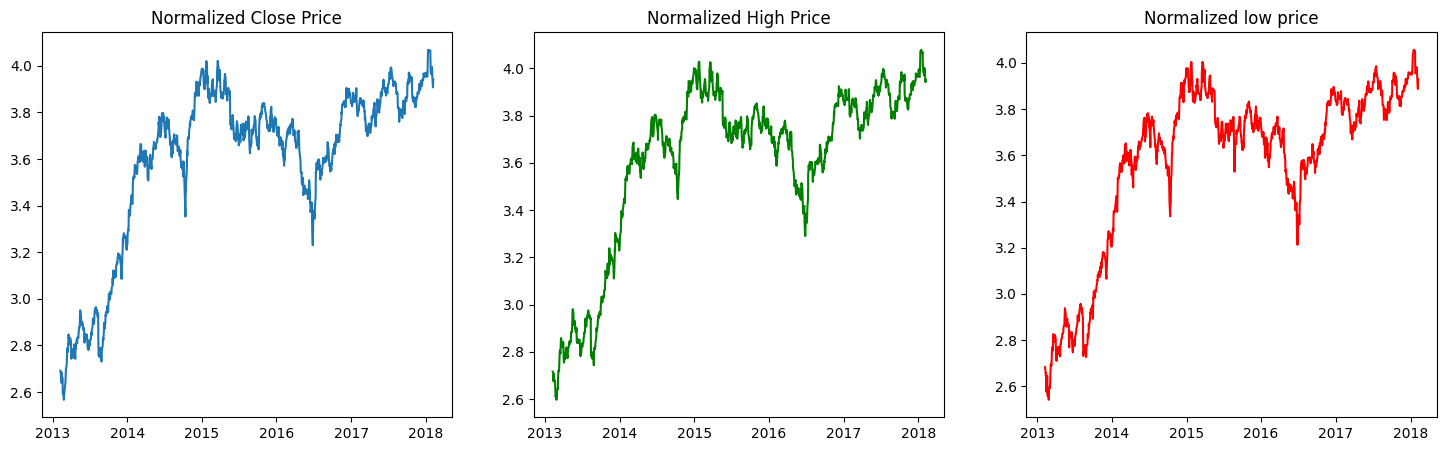

In [28]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize = (18, 5))

aal_df['close_log'] = np.log(aal_df['close'])
aal_df['high_log'] = np.log(aal_df['high'])
aal_df['low_log'] = np.log(aal_df['low'])

ax_1.plot(aal_df['date'], aal_df['close_log'])
ax_1.set_title('Normalized Close Price')
ax_2.plot(aal_df['date'], aal_df['high_log'], color = 'g')
ax_2.set_title('Normalized High Price')
ax_3.plot(aal_df['date'], aal_df['low_log'], color = 'r')
ax_3.set_title('Normalized low price')
plt.show()

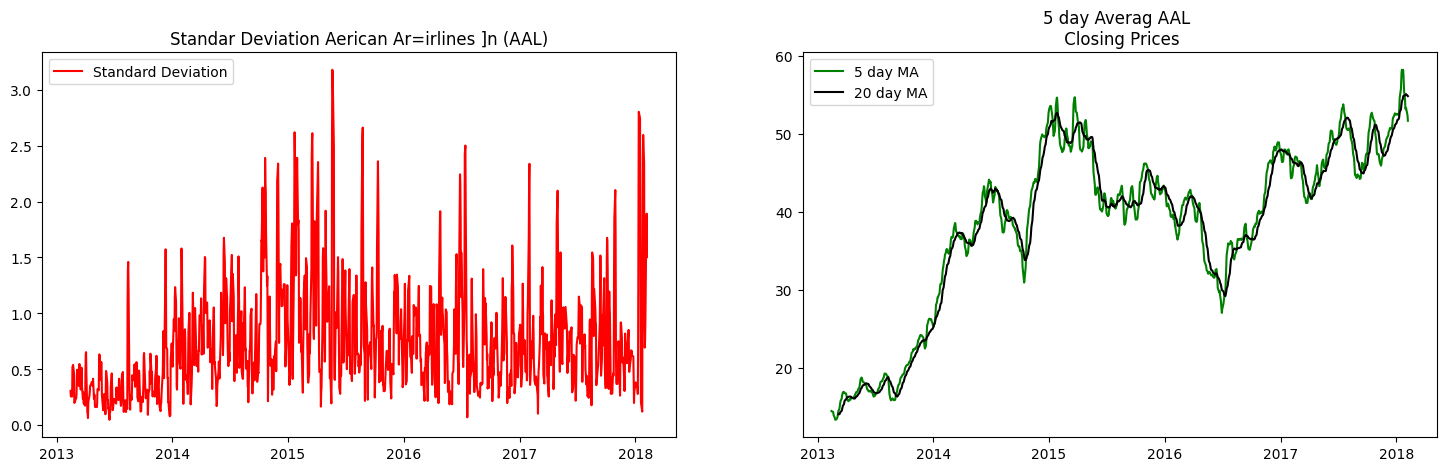

In [29]:
aal_df['std_close'] = aal_df['close'].rolling(5).std()
aal_df['mean_close'] = aal_df['close'].rolling(5).mean()
aal_df['twenty_mean_close'] = aal_df['close'].rolling(20).mean()

fig, (std_ax, avg_ax) = plt.subplots(1, 2, figsize = (18, 5))

std_ax.plot(aal_df['date'], aal_df['std_close'], color = 'r', label = 'Standard Deviation')
std_ax.legend(loc = 'upper left')
std_ax.set_title('Standar Deviation Aerican Ar=irlines ]n (AAL)')

avg_ax.plot(aal_df['date'], aal_df['mean_close'], color = 'g', label = '5 day MA')
avg_ax.plot(aal_df['date'], aal_df['twenty_mean_close'], color = 'k', label = '20 day MA')
avg_ax.legend(loc = 'upper left')
avg_ax.set_title('5 day Averag AAL \n Closing Prices')
plt.show()

In [30]:
m = Prophet()

ph_df = aal_df.drop(['open' ,'high', 'low', 'volume', 'Ticks', 'close_log', 'high_log', 'mean_close', 'twenty_mean_close', 'low_log','std_close'], axis = 1)
ph_df.rename(columns = {'close': 'y', 'date': 'ds'}, inplace = True)

ph_df.head()

,ds,y
0,2013-02-08 00:00:00,14.75
1,2013-02-11 00:00:00,14.46
2,2013-02-12 00:00:00,14.27
3,2013-02-13 00:00:00,14.66
4,2013-02-14 00:00:00,13.99


In [31]:
m.fit(ph_df)

future_prices = m.make_future_dataframe(periods = 365)

forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,64.380585,55.670799,72.613563
1620,2019-02-04,62.571617,53.751509,69.910597
1621,2019-02-05,62.564883,53.831958,70.737677
1622,2019-02-06,62.610067,53.926025,70.713676
1623,2019-02-07,62.590430,53.326683,70.574549


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



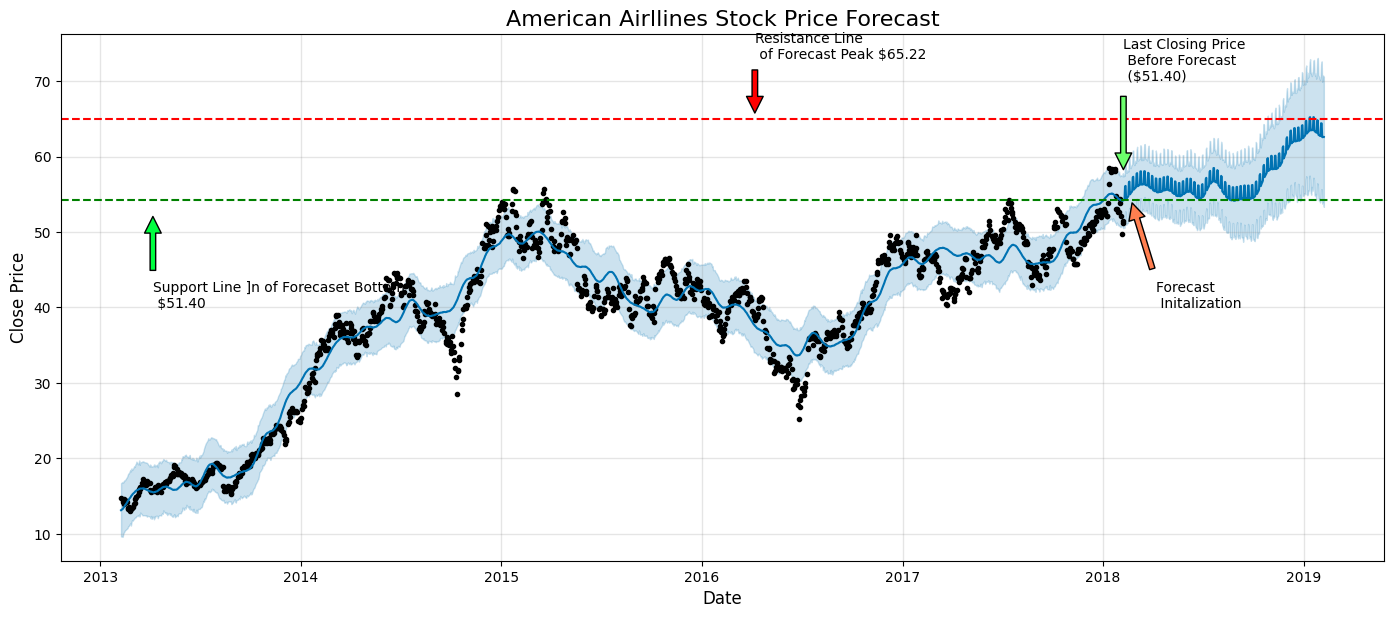

In [32]:
starting_date = dt.datetime(2018, 4, 7)
starting_date_1 = mdates.date2num(starting_date)

trend_date = dt.datetime(2018, 2, 7)
trend_date_1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow_1 = mdates.date2num(pointing_arrow)

resistance_date = dt.datetime(2016, 4, 7)
resistance_date_1 = mdates.date2num(resistance_date)

support_date = dt.datetime(2013, 4, 7)
support_date_1 = mdates.date2num(support_date)

# fig = m.plot(forecast)
fig = plt.figure(figsize=(14, 6))

ax_1 = fig.add_subplot(111)
m.plot(forecast, ax = ax_1)
ax_1.set_title('American Airllines Stock Price Forecast', fontsize=16)
ax_1.set_xlabel('Date', fontsize = 12)
ax_1.set_ylabel('Close Price', fontsize = 12)

ax_1.annotate(
    'Forecast \n Initalization', 
    xy = (pointing_arrow_1, 55), 
    xytext = (starting_date_1, 40) , 
    arrowprops = dict(facecolor='#ff7f50', shrink=0.1)
)

ax_1.annotate(
    'Last Closing Price \n Before Forecast \n ($51.40)', 
    xy=(trend_date_1, 57), 
    xytext=(trend_date_1, 70), 
    arrowprops=dict(facecolor='#6cff6c', shrink = 0.1)
)

ax_1.annotate(
    'Resistance Line \n of Forecast Peak ${:.2f}'.format(forecast['yhat'].max()), 
    xy= (resistance_date_1, 65),
    xytext = (resistance_date_1, 73),
    arrowprops=dict(facecolor='#FF0000', shrink = 0.1)
)

ax_1.annotate(
    'Support Line ]n of Forecaset Bottom \n $51.40',
    xy = (support_date_1, 53),
    xytext = (support_date_1, 40),
    arrowprops=dict(facecolor='#00FF40', shrink=0.1)
)

ax_1.axhline(y = 65, color = 'r', linestyle = '--')
ax_1.axhline(y = 54.2, color = 'g', linestyle = '--')

plt.show()

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



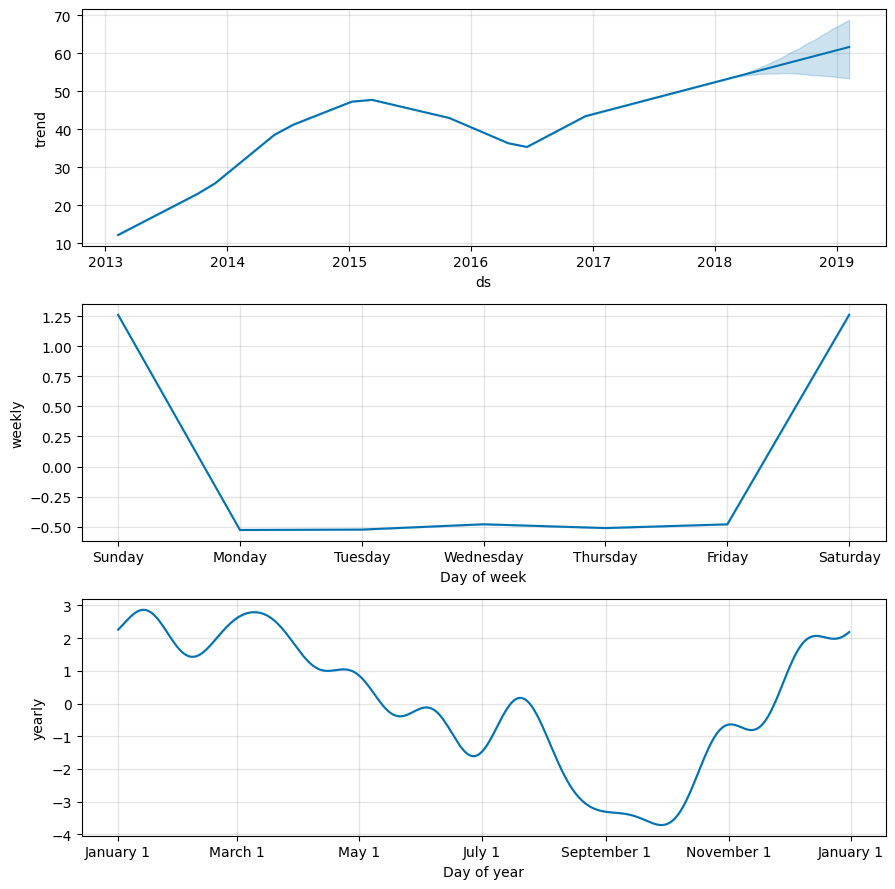

In [33]:
fig_2 = m.plot_components(forecast)
plt.show()

/tmp/ipykernel_17/664349571.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/tmp/ipykernel_17/664349571.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'January' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



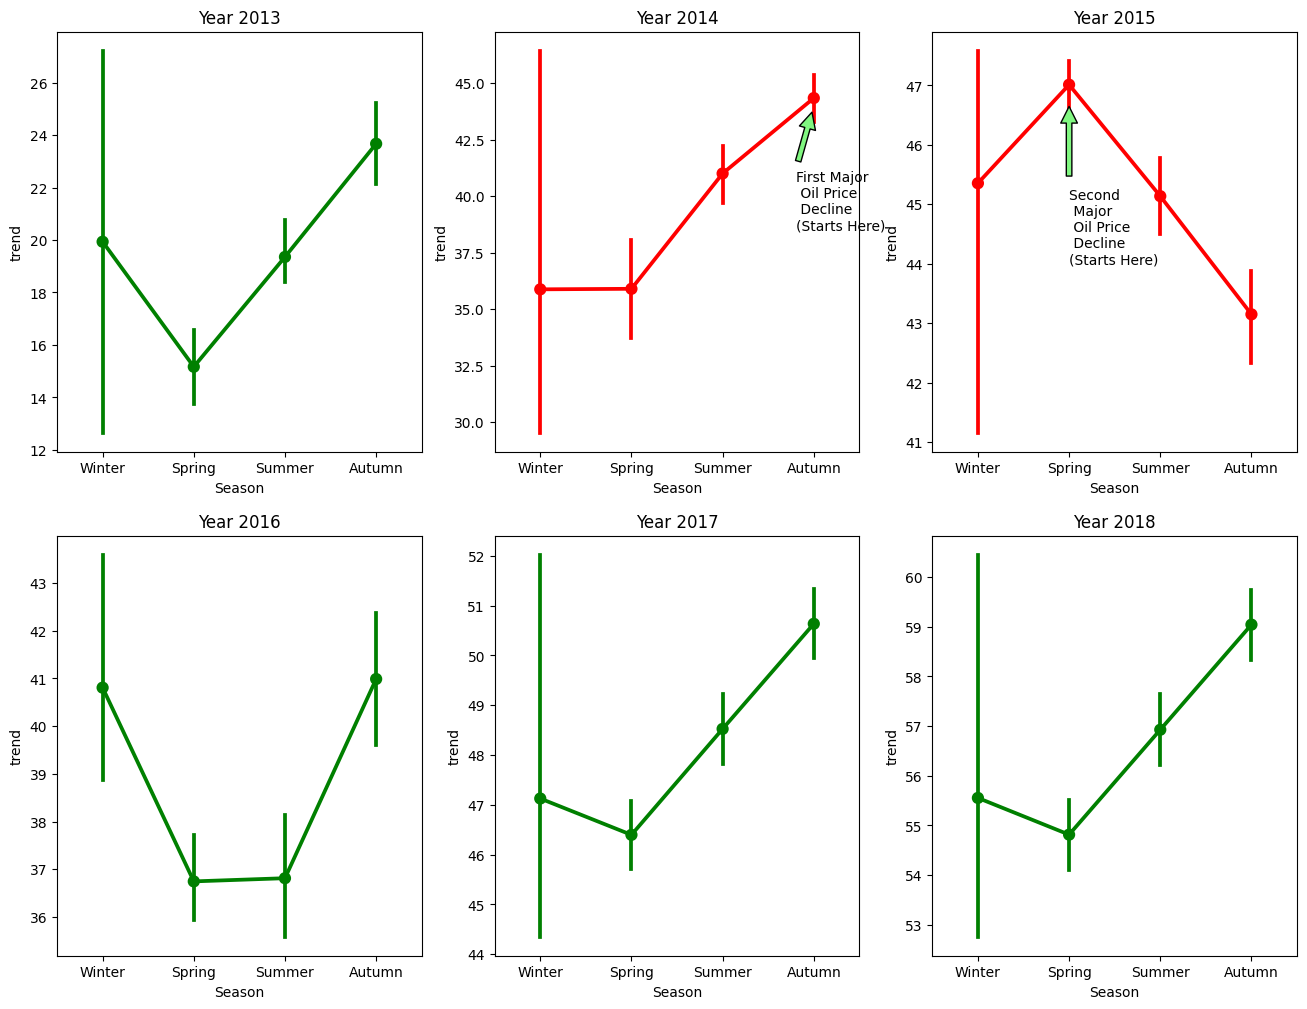

In [34]:
forecast_monthly = forecast.resample('M', on='ds').mean()
forecast_monthly = forecast_monthly.reset_index()

forecast_monthly['month_int'] = forecast_monthly['ds'].dt.month
forecast_monthly['year'] = forecast_monthly['ds'].dt.year

forecast_monthly['month'] = np.nan
lst = [forecast_monthly]

for column in lst:
    column.loc[column["month_int"] == 1, "month"] = "January"
    column.loc[column["month_int"] == 2, "month"] = "February"
    column.loc[column["month_int"] == 3, "month"] = "March"
    column.loc[column["month_int"] == 4, "month"] = "April"
    column.loc[column["month_int"] == 5, "month"] = "May"
    column.loc[column["month_int"] == 6, "month"] = "June"
    column.loc[column["month_int"] == 7, "month"] = "July"
    column.loc[column["month_int"] == 8, "month"] = "August"
    column.loc[column["month_int"] == 9, "month"] = "September"
    column.loc[column["month_int"] == 10, "month"] = "October"
    column.loc[column["month_int"] == 11, "month"] = "November"
    column.loc[column["month_int"] == 12, "month"] = "December"

forecast_monthly['season'] = np.nan
lst_2 = [forecast_monthly]

for column in lst_2:
    column.loc[(column['month_int'] > 2) & (column['month_int'] <= 5), 'Season'] = 'Spring'
    column.loc[(column['month_int'] > 5) & (column['month_int'] <= 8), 'Season'] = 'Summer'
    column.loc[(column['month_int'] > 8) & (column['month_int'] <= 11), 'Season'] = 'Autumn'
    column.loc[column['month_int'] <= 2, 'Season'] = 'Winter'
    column.loc[column['month_int'] == 12, 'Season'] = 'Winter'
    
    
df_2013 = forecast_monthly.loc[(forecast_monthly['year'] == 2013)]
df_2014 = forecast_monthly.loc[(forecast_monthly['year'] == 2014)]
df_2015 = forecast_monthly.loc[(forecast_monthly["year"] == 2015)]
df_2016 = forecast_monthly.loc[(forecast_monthly["year"] == 2016)]
df_2017 = forecast_monthly.loc[(forecast_monthly["year"] == 2017)]
df_2018 = forecast_monthly.loc[(forecast_monthly["year"] == 2018)]

fig, ((ax_1, ax_2, ax_3), (ax_4,ax_5, ax_6)) = plt.subplots(2, 3, figsize=(16, 12))

sns.pointplot(x = 'Season', y = 'trend', data = df_2013, ax = ax_1, color = 'g')

sns.pointplot(x = 'Season', y = 'trend', data = df_2014, ax = ax_2, color = 'r')

sns.pointplot(x = 'Season', y = 'trend', data = df_2015, ax = ax_3, color = 'r')

sns.pointplot(x = 'Season', y = 'trend', data = df_2016, ax = ax_4, color = 'g')

sns.pointplot(x = 'Season', y = 'trend', data = df_2017, ax = ax_5, color = 'g')

sns.pointplot(x = 'Season', y = 'trend', data = df_2018, ax = ax_6, color = 'g')

ax_1.set_title("Year 2013")
ax_2.set_title("Year 2014")
ax_3.set_title("Year 2015")
ax_4.set_title("Year 2016")
ax_5.set_title("Year 2017")
ax_6.set_title("Year 2018")

ax_2.annotate(
    'First Major \n Oil Price \n Decline \n(Starts Here)', 
    xy=(3, 44), 
    xytext=(2.8,38.5),
    arrowprops=dict(facecolor='#81F781', shrink=0.1),
)


ax_3.annotate(
    'Second \n Major \n Oil Price \n Decline \n(Starts Here)', 
    xy=(1, 46.8), 
    xytext=(1,44),
    arrowprops=dict(facecolor='#81F781', shrink=0.1),
)

plt.show()

# Reference

- https://www.kaggle.com/code/janiobachmann/s-p-500-time-series-forecasting-with-prophet
- https://research.facebook.com/blog/2017/2/prophet-forecasting-at-scale/
- https://github.com/facebook/prophet/issues/1223